In [2]:
import torch

import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [3]:
trainset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=True, download=False)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/datasets/CIFAR-10', train=False, download=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

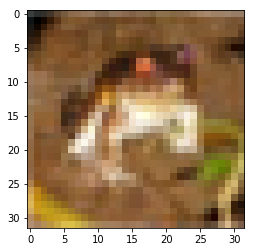

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(trainset[0][0])
plt.show()

In [5]:
def plot_images(images, cls_true, cls_pred=None):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    for i, ax in enumerate(axes.flat):
        # plot the image
        ax.imshow(images[i, :, :, :], interpolation='spline16')
        # get its equivalent class name
        cls_true_name = classes[cls_true[i]]
            
        if cls_pred is None:
            xlabel = "{0} ({1})".format(cls_true_name, cls_true[i])
        else:
            cls_pred_name = label_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)
            
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

In [6]:
# This is an example for the CIFAR-10 dataset.
# There's a function for creating a train and validation iterator.
# There's also a function for creating a test iterator.
# Inspired by https://discuss.pytorch.org/t/feedback-on-pytorch-for-kaggle-competitions/2252/4

def get_train_valid_loader(data_dir,
                           batch_size,
                           norm=False,
                           random_seed=22,
                           valid_size=0.1,
                           shuffle=True,
                           show_sample=False,
                           num_workers=4,
                           pin_memory=False):
    """
    Utility function for loading and returning train and valid 
    multi-process iterators over the CIFAR-10 dataset. A sample 
    9x9 grid of the images can be optionally displayed.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - norm: bactch normalization
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    if norm:
        train_transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            normalize
        ])
        
        valid_transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            normalize
        ])
    else:
        train_transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
        ])
        
        valid_transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
        ])

    # load the dataset
    train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, 
                download=False, transform=train_transform)

    valid_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, 
                download=False, transform=valid_transform)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
    valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, 
                    batch_size=batch_size, sampler=train_sampler, 
                    num_workers=num_workers, pin_memory=pin_memory)

    valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                    batch_size=batch_size, sampler=valid_sampler, 
                    num_workers=num_workers, pin_memory=pin_memory)


    # visualize some images
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(train_dataset, 
                                                    batch_size=9, 
                                                    shuffle=shuffle, 
                                                    num_workers=num_workers,
                                                    pin_memory=pin_memory)
        data_iter = iter(sample_loader)
        images, labels = data_iter.next()
        X = images.numpy()
        X = np.transpose(X, [0, 2, 3, 1])
        plot_images(X, labels)

    return (train_loader, valid_loader)
    
def get_test_loader(data_dir, 
                    batch_size,
                    norm=False,
                    shuffle=True,
                    num_workers=4,
                    pin_memory=False):
    """
    Utility function for loading and returning a multi-process 
    test iterator over the CIFAR-10 dataset.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - norm: batch normalization
    - shuffle: whether to shuffle the dataset after every epoch.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - data_loader: test set iterator.
    """
    normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    # define transform
    if norm:
        transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            normalize
        ])
    else:
        transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
        ])

    dataset = torchvision.datasets.CIFAR10(root=data_dir, 
                               train=False, 
                               download=False,
                               transform=transform)

    data_loader = torch.utils.data.DataLoader(dataset, 
                                              batch_size=batch_size, 
                                              shuffle=shuffle, 
                                              num_workers=num_workers,
                                              pin_memory=pin_memory)

    return data_loader

In [7]:
def percent_correct(net, loader, mode):
    correct = 0
    total = 0
    
    for data in loader:
        images, labels = data
        outputs = net(Variable(images.cuda()))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()

    print('Accuracy of the network on the %d %s images: %.2f %%' % (total, mode, 100. * correct / total))
    return 100. * correct / total

In [8]:
def compute_loss(net, loader):
    criterion = nn.CrossEntropyLoss()
    running_loss = 0.0
    
    for data in loader:
        images, labels = data
        outputs = net(Variable(images.cuda()))
        loss = criterion(outputs, Variable(labels.cuda()))
        running_loss += loss.data[0]
    
    return running_loss/len(loader)

In [9]:
def train(net, 
          opt,
          epoch=100,
          learning_rate=0.001):
    '''
    param: net neural network
    param: opt optimizer type
    param: epoch 
    param: learning_rate
    param: p_batch print batch size
    '''
    net.cuda()
    criterion = nn.CrossEntropyLoss()
    if opt=="Adam":
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    elif opt=="SGD":
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    
    loss_train = []
    loss_validation = []
    percentage_train = []
    percentage_validation = []

    for p in range(epoch):  # loop over the dataset multiple times
        
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.data[0]
        
        print('epoch: %d' % (p+1))
        print('Train Loss: %.3f' % (running_loss/len(train_loader)))
        loss_train.append(running_loss/len(train_loader))
        loss_validation.append(compute_loss(net, validation_loader))
        percentage_train.append(percent_correct(net, train_loader, "train"))
        percentage_validation.append(percent_correct(net, validation_loader, "validation"))
        
    print('Finished Training')
    percent_correct(net, test_loader, "test")
    print('Test Loss %.3f' % (compute_loss(net, test_loader)))
    print('Finished Testing')
    print('Plot')
    
    plt.figure()
    plt.title('Loss')
    plt.plot(loss_train, label='loss_train')
    plt.plot(loss_validation, label='loss_validation')
    plt.legend()
    plt.show()
    
    plt.figure()
    plt.title('Percent Correct')
    plt.plot(percentage_train, label='percent_train')
    plt.plot(percentage_validation, label='percent_validation')
    plt.legend()
    plt.show()

## Net: 2 Convolution + 3 linear Batch Normalization

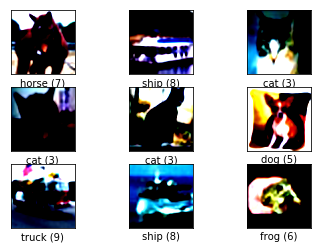

In [67]:
train_loader, validation_loader = get_train_valid_loader('/datasets/CIFAR-10',
                        128,
                        norm=True,
                        random_seed=22,
                        valid_size=0.1,
                        shuffle=True,
                        show_sample=True,
                        num_workers=4,
                        pin_memory=False)

test_loader = get_test_loader('/datasets/CIFAR-10', 
                    128,
                    norm=True,
                    shuffle=True,
                    num_workers=4,
                    pin_memory=False)

In [71]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

epoch: 1
Train Loss: 2.290
Accuracy of the network on the 45000 train images: 16.12 %
Accuracy of the network on the 5000 validation images: 15.94 %
epoch: 2
Train Loss: 2.152
Accuracy of the network on the 45000 train images: 25.96 %
Accuracy of the network on the 5000 validation images: 26.52 %
epoch: 3
Train Loss: 1.981
Accuracy of the network on the 45000 train images: 30.02 %
Accuracy of the network on the 5000 validation images: 30.40 %
epoch: 4
Train Loss: 1.864
Accuracy of the network on the 45000 train images: 34.56 %
Accuracy of the network on the 5000 validation images: 34.66 %
epoch: 5
Train Loss: 1.713
Accuracy of the network on the 45000 train images: 39.53 %
Accuracy of the network on the 5000 validation images: 39.04 %
epoch: 6
Train Loss: 1.607
Accuracy of the network on the 45000 train images: 42.37 %
Accuracy of the network on the 5000 validation images: 42.68 %
epoch: 7
Train Loss: 1.541
Accuracy of the network on the 45000 train images: 44.78 %
Accuracy of the netw

epoch: 56
Train Loss: 0.774
Accuracy of the network on the 45000 train images: 74.20 %
Accuracy of the network on the 5000 validation images: 63.94 %
epoch: 57
Train Loss: 0.762
Accuracy of the network on the 45000 train images: 74.63 %
Accuracy of the network on the 5000 validation images: 64.28 %
epoch: 58
Train Loss: 0.758
Accuracy of the network on the 45000 train images: 74.36 %
Accuracy of the network on the 5000 validation images: 63.50 %
epoch: 59
Train Loss: 0.747
Accuracy of the network on the 45000 train images: 74.83 %
Accuracy of the network on the 5000 validation images: 64.08 %
epoch: 60
Train Loss: 0.737
Accuracy of the network on the 45000 train images: 74.90 %
Accuracy of the network on the 5000 validation images: 63.98 %
epoch: 61
Train Loss: 0.737
Accuracy of the network on the 45000 train images: 75.17 %
Accuracy of the network on the 5000 validation images: 63.80 %
epoch: 62
Train Loss: 0.724
Accuracy of the network on the 45000 train images: 75.09 %
Accuracy of t

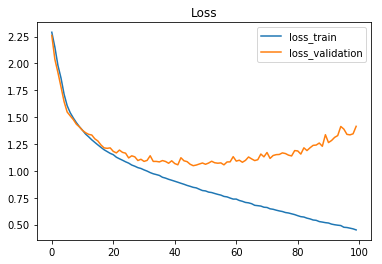

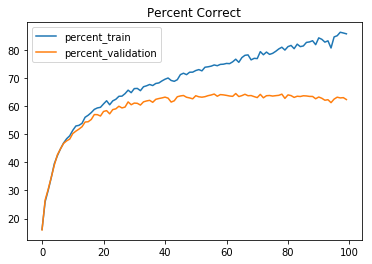

In [73]:
net = Net()
train(net, "SGD", epoch=100 ,learning_rate=0.001)

## Net: 2 Convolution + 3 Linear Batch Normalization Adam Optimizer

epoch: 1
Train Loss: 1.655
Accuracy of the network on the 45000 train images: 46.52 %
Accuracy of the network on the 5000 validation images: 44.74 %
epoch: 2
Train Loss: 1.386
Accuracy of the network on the 45000 train images: 52.96 %
Accuracy of the network on the 5000 validation images: 51.26 %
epoch: 3
Train Loss: 1.269
Accuracy of the network on the 45000 train images: 55.37 %
Accuracy of the network on the 5000 validation images: 53.22 %
epoch: 4
Train Loss: 1.192
Accuracy of the network on the 45000 train images: 58.54 %
Accuracy of the network on the 5000 validation images: 54.78 %
epoch: 5
Train Loss: 1.127
Accuracy of the network on the 45000 train images: 62.62 %
Accuracy of the network on the 5000 validation images: 58.76 %
epoch: 6
Train Loss: 1.076
Accuracy of the network on the 45000 train images: 64.26 %
Accuracy of the network on the 5000 validation images: 60.14 %
epoch: 7
Train Loss: 1.024
Accuracy of the network on the 45000 train images: 65.54 %
Accuracy of the netw

epoch: 56
Train Loss: 0.231
Accuracy of the network on the 45000 train images: 88.80 %
Accuracy of the network on the 5000 validation images: 58.28 %
epoch: 57
Train Loss: 0.234
Accuracy of the network on the 45000 train images: 93.34 %
Accuracy of the network on the 5000 validation images: 59.62 %
epoch: 58
Train Loss: 0.223
Accuracy of the network on the 45000 train images: 92.70 %
Accuracy of the network on the 5000 validation images: 59.40 %
epoch: 59
Train Loss: 0.230
Accuracy of the network on the 45000 train images: 92.38 %
Accuracy of the network on the 5000 validation images: 58.74 %
epoch: 60
Train Loss: 0.220
Accuracy of the network on the 45000 train images: 92.83 %
Accuracy of the network on the 5000 validation images: 59.28 %
epoch: 61
Train Loss: 0.212
Accuracy of the network on the 45000 train images: 93.79 %
Accuracy of the network on the 5000 validation images: 58.64 %
epoch: 62
Train Loss: 0.208
Accuracy of the network on the 45000 train images: 94.96 %
Accuracy of t

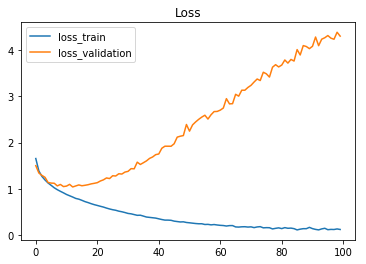

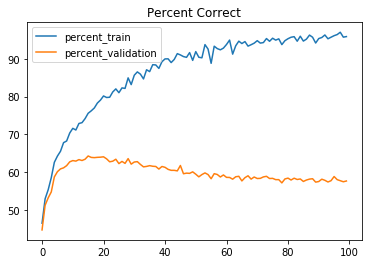

In [74]:
net = Net()
train(net, "Adam", epoch=100, learning_rate=0.001)

## Net: 2 Convolution + 3 Linear No Batch Normalization SGD

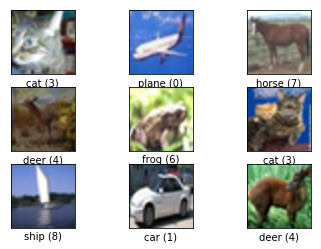

In [75]:
train_loader, validation_loader = get_train_valid_loader('/datasets/CIFAR-10',
                        128,
                        norm=False,
                        random_seed=22,
                        valid_size=0.1,
                        shuffle=True,
                        show_sample=True,
                        num_workers=4,
                        pin_memory=False)

test_loader = get_test_loader('/datasets/CIFAR-10', 
                    100,
                    norm=False,
                    shuffle=True,
                    num_workers=4,
                    pin_memory=False)

epoch: 1
Train Loss: 2.303
Accuracy of the network on the 45000 train images: 9.98 %
Accuracy of the network on the 5000 validation images: 10.24 %
epoch: 2
Train Loss: 2.300
Accuracy of the network on the 45000 train images: 10.18 %
Accuracy of the network on the 5000 validation images: 10.62 %
epoch: 3
Train Loss: 2.294
Accuracy of the network on the 45000 train images: 10.40 %
Accuracy of the network on the 5000 validation images: 10.74 %
epoch: 4
Train Loss: 2.272
Accuracy of the network on the 45000 train images: 15.74 %
Accuracy of the network on the 5000 validation images: 16.00 %
epoch: 5
Train Loss: 2.134
Accuracy of the network on the 45000 train images: 24.47 %
Accuracy of the network on the 5000 validation images: 24.24 %
epoch: 6
Train Loss: 2.009
Accuracy of the network on the 45000 train images: 26.56 %
Accuracy of the network on the 5000 validation images: 26.48 %
epoch: 7
Train Loss: 1.977
Accuracy of the network on the 45000 train images: 27.76 %
Accuracy of the netwo

epoch: 56
Train Loss: 1.040
Accuracy of the network on the 45000 train images: 64.10 %
Accuracy of the network on the 5000 validation images: 58.64 %
epoch: 57
Train Loss: 1.034
Accuracy of the network on the 45000 train images: 63.08 %
Accuracy of the network on the 5000 validation images: 57.40 %
epoch: 58
Train Loss: 1.024
Accuracy of the network on the 45000 train images: 63.82 %
Accuracy of the network on the 5000 validation images: 57.92 %
epoch: 59
Train Loss: 1.012
Accuracy of the network on the 45000 train images: 64.83 %
Accuracy of the network on the 5000 validation images: 59.04 %
epoch: 60
Train Loss: 1.008
Accuracy of the network on the 45000 train images: 65.60 %
Accuracy of the network on the 5000 validation images: 59.40 %
epoch: 61
Train Loss: 1.003
Accuracy of the network on the 45000 train images: 66.21 %
Accuracy of the network on the 5000 validation images: 59.32 %
epoch: 62
Train Loss: 0.993
Accuracy of the network on the 45000 train images: 64.77 %
Accuracy of t

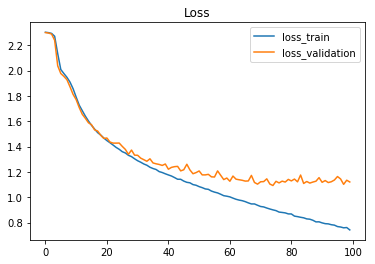

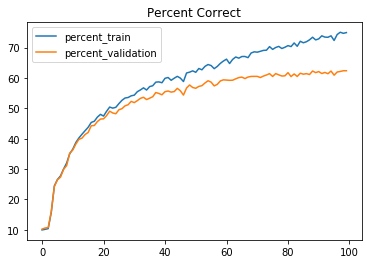

In [76]:
net = Net()
train(net, "SGD", epoch=100, learning_rate=0.001)

## Net: 2 Convolution + 3 Linear + Batch Normalization + Xavier Normalization + Adam Optimizer

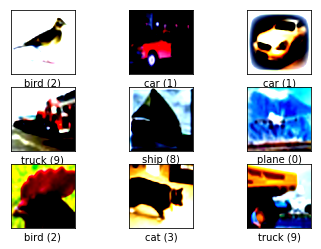

In [77]:
train_loader, validation_loader = get_train_valid_loader('/datasets/CIFAR-10',
                        128,
                        norm=True,
                        random_seed=22,
                        valid_size=0.1,
                        shuffle=True,
                        show_sample=True,
                        num_workers=4,
                        pin_memory=False)

test_loader = get_test_loader('/datasets/CIFAR-10', 
                    15,
                    norm=True,
                    shuffle=True,
                    num_workers=4,
                    pin_memory=False)

In [78]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        torch.nn.init.xavier_normal(self.conv1.weight)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        torch.nn.init.xavier_normal(self.conv2.weight)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        torch.nn.init.xavier_normal(self.fc1.weight)
        self.fc2 = nn.Linear(120, 84)
        torch.nn.init.xavier_normal(self.fc2.weight)
        self.fc3 = nn.Linear(84, 10)
        torch.nn.init.xavier_normal(self.fc3.weight)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

epoch: 1
Train Loss: 1.648
Accuracy of the network on the 45000 train images: 49.54 %
Accuracy of the network on the 5000 validation images: 49.52 %
epoch: 2
Train Loss: 1.351
Accuracy of the network on the 45000 train images: 54.34 %
Accuracy of the network on the 5000 validation images: 52.32 %
epoch: 3
Train Loss: 1.257
Accuracy of the network on the 45000 train images: 58.04 %
Accuracy of the network on the 5000 validation images: 54.66 %
epoch: 4
Train Loss: 1.183
Accuracy of the network on the 45000 train images: 60.01 %
Accuracy of the network on the 5000 validation images: 56.88 %
epoch: 5
Train Loss: 1.124
Accuracy of the network on the 45000 train images: 62.36 %
Accuracy of the network on the 5000 validation images: 58.32 %
epoch: 6
Train Loss: 1.081
Accuracy of the network on the 45000 train images: 63.82 %
Accuracy of the network on the 5000 validation images: 58.98 %
epoch: 7
Train Loss: 1.033
Accuracy of the network on the 45000 train images: 66.28 %
Accuracy of the netw

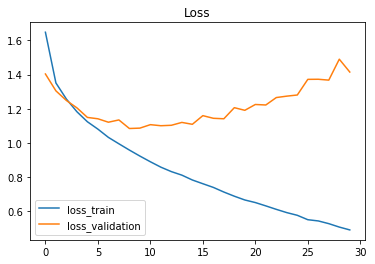

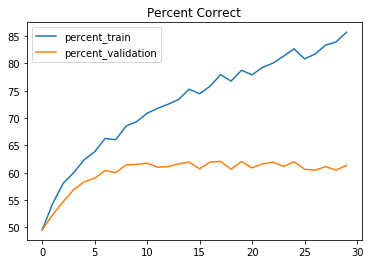

In [79]:
net = Net3()
train(net, "Adam", epoch=30, learning_rate=0.001)

epoch: 1
Train Loss: 2.080
Accuracy of the network on the 45000 train images: 33.23 %
Accuracy of the network on the 5000 validation images: 32.82 %
epoch: 2
Train Loss: 1.770
Accuracy of the network on the 45000 train images: 39.95 %
Accuracy of the network on the 5000 validation images: 39.26 %
epoch: 3
Train Loss: 1.622
Accuracy of the network on the 45000 train images: 43.27 %
Accuracy of the network on the 5000 validation images: 42.16 %
epoch: 4
Train Loss: 1.530
Accuracy of the network on the 45000 train images: 45.58 %
Accuracy of the network on the 5000 validation images: 45.48 %
epoch: 5
Train Loss: 1.474
Accuracy of the network on the 45000 train images: 48.36 %
Accuracy of the network on the 5000 validation images: 46.84 %
epoch: 6
Train Loss: 1.428
Accuracy of the network on the 45000 train images: 49.58 %
Accuracy of the network on the 5000 validation images: 48.00 %
epoch: 7
Train Loss: 1.395
Accuracy of the network on the 45000 train images: 50.78 %
Accuracy of the netw

epoch: 56
Train Loss: 0.784
Accuracy of the network on the 45000 train images: 73.31 %
Accuracy of the network on the 5000 validation images: 63.84 %
epoch: 57
Train Loss: 0.780
Accuracy of the network on the 45000 train images: 73.23 %
Accuracy of the network on the 5000 validation images: 64.04 %
epoch: 58
Train Loss: 0.775
Accuracy of the network on the 45000 train images: 74.61 %
Accuracy of the network on the 5000 validation images: 64.12 %
epoch: 59
Train Loss: 0.764
Accuracy of the network on the 45000 train images: 74.00 %
Accuracy of the network on the 5000 validation images: 63.48 %
epoch: 60
Train Loss: 0.759
Accuracy of the network on the 45000 train images: 74.85 %
Accuracy of the network on the 5000 validation images: 64.24 %
epoch: 61
Train Loss: 0.754
Accuracy of the network on the 45000 train images: 74.57 %
Accuracy of the network on the 5000 validation images: 63.78 %
epoch: 62
Train Loss: 0.746
Accuracy of the network on the 45000 train images: 75.16 %
Accuracy of t

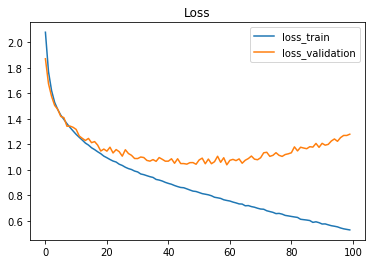

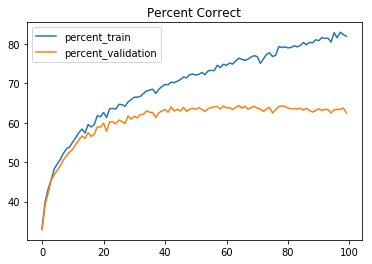

In [80]:
net = Net3()
train(net, "SGD", epoch=100, learning_rate=0.001)

## Net4: 3 convolution + 1 linear filter size=3

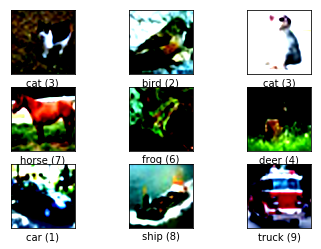

In [10]:
train_loader, validation_loader = get_train_valid_loader('/datasets/CIFAR-10',
                        128,
                        norm=True,
                        random_seed=22,
                        valid_size=0.1,
                        shuffle=True,
                        show_sample=True,
                        num_workers=4,
                        pin_memory=False)

test_loader = get_test_loader('/datasets/CIFAR-10', 
                    128,
                    norm=True,
                    shuffle=True,
                    num_workers=4,
                    pin_memory=False)

In [44]:
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        torch.nn.init.xavier_normal(self.conv1.weight)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 256, 3, padding=1)
        torch.nn.init.xavier_normal(self.conv2.weight)
        self.conv3 = nn.Conv2d(256, 512, 3, padding=1)
        torch.nn.init.xavier_normal(self.conv3.weight)
        self.conv4 = nn.Conv2d(512, 1024, 3, padding=1)
        torch.nn.init.xavier_normal(self.conv3.weight)
        
        self.fc1 = nn.Linear(2*2*1024, 120)
        torch.nn.init.xavier_normal(self.fc1.weight)
        self.fc2 = nn.Linear(120, 84)
        torch.nn.init.xavier_normal(self.fc2.weight)
        self.fc3 = nn.Linear(84, 10)
        torch.nn.init.xavier_normal(self.fc3.weight)
        self.fc4 = nn.Linear(2*2*1024, 10)
        torch.nn.init.xavier_normal(self.fc4.weight)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 2*2*1024)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
        x = self.fc4(x)
        return x

epoch: 1
Train Loss: 1.487
Accuracy of the network on the 45000 train images: 58.15 %
Accuracy of the network on the 5000 validation images: 56.52 %
epoch: 2
Train Loss: 1.125
Accuracy of the network on the 45000 train images: 66.46 %
Accuracy of the network on the 5000 validation images: 63.06 %
epoch: 3
Train Loss: 0.961
Accuracy of the network on the 45000 train images: 67.71 %
Accuracy of the network on the 5000 validation images: 63.38 %
epoch: 4
Train Loss: 0.837
Accuracy of the network on the 45000 train images: 75.19 %
Accuracy of the network on the 5000 validation images: 70.10 %
epoch: 5
Train Loss: 0.740
Accuracy of the network on the 45000 train images: 77.57 %
Accuracy of the network on the 5000 validation images: 71.34 %
epoch: 6
Train Loss: 0.658
Accuracy of the network on the 45000 train images: 81.48 %
Accuracy of the network on the 5000 validation images: 73.56 %
epoch: 7
Train Loss: 0.587
Accuracy of the network on the 45000 train images: 82.79 %
Accuracy of the netw

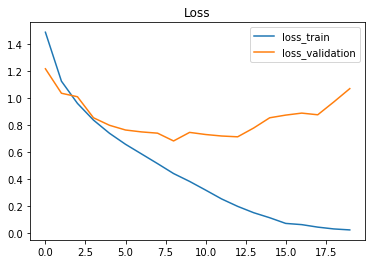

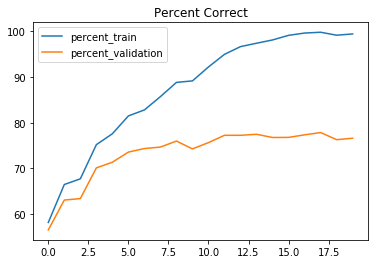

In [66]:
net = Net4()
train(net, "Adam", epoch=20, learning_rate=0.0001)

## Net5: 4convolution + 3Linear filter size=7

In [84]:
class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 7, padding=3)
        torch.nn.init.xavier_normal(self.conv1.weight)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 256, 7, padding=3)
        torch.nn.init.xavier_normal(self.conv2.weight)
        self.conv3 = nn.Conv2d(256, 512, 7, padding=3)
        torch.nn.init.xavier_normal(self.conv3.weight)
        self.conv4 = nn.Conv2d(512, 1024, 7, padding=3)
        torch.nn.init.xavier_normal(self.conv3.weight)
        
        self.fc1 = nn.Linear(2*2*1024, 120)
        torch.nn.init.xavier_normal(self.fc1.weight)
        self.fc2 = nn.Linear(120, 84)
        torch.nn.init.xavier_normal(self.fc2.weight)
        self.fc3 = nn.Linear(84, 10)
        torch.nn.init.xavier_normal(self.fc3.weight)
        self.fc4 = nn.Linear(2*2*1024, 10)
        torch.nn.init.xavier_normal(self.fc4.weight)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 2*2*1024)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
        x = self.fc4(x)
        return x

epoch: 1
Train Loss: 1.445
Accuracy of the network on the 45000 train images: 61.05 %
Accuracy of the network on the 5000 validation images: 58.62 %
epoch: 2
Train Loss: 1.005
Accuracy of the network on the 45000 train images: 69.47 %
Accuracy of the network on the 5000 validation images: 64.84 %
epoch: 3
Train Loss: 0.786
Accuracy of the network on the 45000 train images: 78.92 %
Accuracy of the network on the 5000 validation images: 71.38 %
epoch: 4
Train Loss: 0.609
Accuracy of the network on the 45000 train images: 85.14 %
Accuracy of the network on the 5000 validation images: 73.10 %
epoch: 5
Train Loss: 0.442
Accuracy of the network on the 45000 train images: 91.47 %
Accuracy of the network on the 5000 validation images: 74.80 %
epoch: 6
Train Loss: 0.284
Accuracy of the network on the 45000 train images: 95.93 %
Accuracy of the network on the 5000 validation images: 75.56 %
epoch: 7
Train Loss: 0.163
Accuracy of the network on the 45000 train images: 98.37 %
Accuracy of the netw

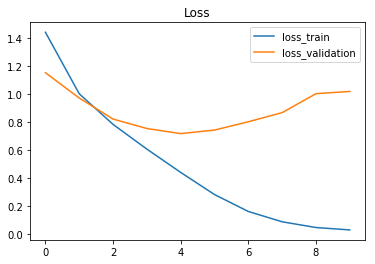

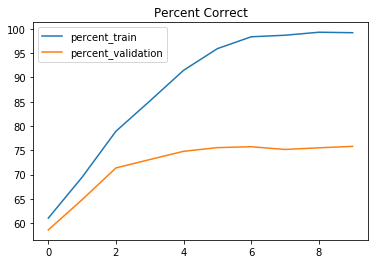

In [86]:
net = Net5()
train(net, "Adam", epoch=10, learning_rate=0.0001)

## Net6: 3 Convolution + 2Linear + 1Softmax

In [11]:
class Net6(nn.Module):
    def __init__(self):
        super(Net6, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
        torch.nn.init.xavier_normal(self.conv1.weight)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, 5, padding=2)
        torch.nn.init.xavier_normal(self.conv2.weight)
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        torch.nn.init.xavier_normal(self.conv3.weight)
        
        self.fc1 = nn.Linear(8*8*64, 64)
        torch.nn.init.xavier_normal(self.fc1.weight)
        self.fc2 = nn.Linear(64, 10)
        torch.nn.init.xavier_normal(self.fc2.weight)
        
        self.softmax = nn.Softmax()
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 8*8*64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)

        return x

epoch: 1
Train Loss: 2.084
Accuracy of the network on the 45000 train images: 44.93 %
Accuracy of the network on the 5000 validation images: 44.26 %
epoch: 2
Train Loss: 1.994
Accuracy of the network on the 45000 train images: 50.55 %
Accuracy of the network on the 5000 validation images: 50.10 %
epoch: 3
Train Loss: 1.918
Accuracy of the network on the 45000 train images: 55.74 %
Accuracy of the network on the 5000 validation images: 54.66 %
epoch: 4
Train Loss: 1.869
Accuracy of the network on the 45000 train images: 63.55 %
Accuracy of the network on the 5000 validation images: 60.64 %
epoch: 5
Train Loss: 1.835
Accuracy of the network on the 45000 train images: 64.38 %
Accuracy of the network on the 5000 validation images: 61.10 %
epoch: 6
Train Loss: 1.814
Accuracy of the network on the 45000 train images: 67.77 %
Accuracy of the network on the 5000 validation images: 64.20 %
epoch: 7
Train Loss: 1.796
Accuracy of the network on the 45000 train images: 69.22 %
Accuracy of the netw

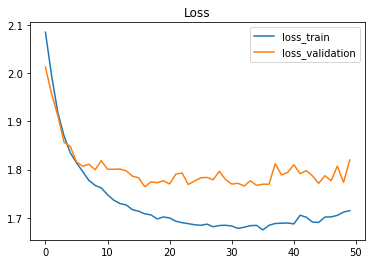

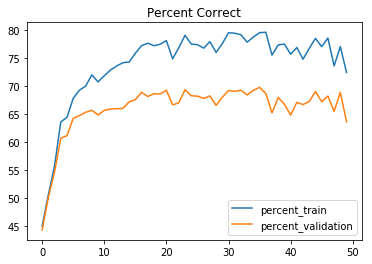

In [12]:
net = Net6()
train(net, "Adam", epoch=50, learning_rate=0.001)